<b> Exercise 1:</b> Convolutional AutoEncoder

<ol>
<li>Load MNIST train and test sets. Split the original training data into 95% training and 5% validation data.</li>
<li>Implement a convolutional autoencoder (with separate Encoder and Decoder modules).</li>
<li>Train the convolutional autoencoder, with different bottleneck sizes. Plot the train and validation loss curves of all autoencoders in the same figure.</li>
<li>Compute the avg. image reconstruction error (MSE) of the trained models on the MNIST validation and test sets. Show the results in a table, including #params of each model.</li>
<li>Select one of the autoencoders and feed it 5 random MNIST images from the test set. Show them along with their reconstructions.</li>
<li>Generate 5 new images by injecting random values as input to the decoder. Show them.</li>

</ol>


<h3><b> Import Libraries</b>
</h3>

In [0]:
import numpy as np
import torch
import random
import matplotlib.pyplot as plt

from torch import optim, nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.functional import F
from collections import defaultdict

<h3><b>Setting the seed for the pseudo-random number generators </b></h3>

In [0]:
# Set seed for reproducibility
seed = 50 
torch.manual_seed(seed)
np.random.seed(seed)

In [0]:
hparams = {
    'batch_size':256, 
    'num_epochs':10,
    'test_batch_size': 256,
    'hidden_size':128,
    'num_classes':10,
    'num_inputs':784,
    'learning_rate':1e-3,
    'log_batch_freq': 10,
    'train_ratio': 0.8
}

hparams['device'] = 'cuda' if torch.cuda.is_available() else 'cpu'

<h3><b> Loading the Dataset</b></h3>
The transformations passed with the kwarg <b>transform=</b> are used to have zero-mean and unit-variance data. The first value is the dataset mean, whether the second is its variance.

In [4]:
mnist_trainset = datasets.MNIST('data', train=True, download=True,
                                transform=transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.1307,), (0.3081,))
                                ]))
mnist_testset = datasets.MNIST('data', train=False, 
                               transform=transforms.Compose([
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.1307,), (0.3081,))
                               ]))

0it [00:00, ?it/s]

9920512it [00:01, 8927205.68it/s]                            


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 131114.39it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


1654784it [00:00, 2081924.91it/s]                            
0it [00:00, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


8192it [00:00, 47718.28it/s]            


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


<b><h3> Get 5% of train samples as validation samples</b> </h3>


In [5]:
train_size = len(mnist_trainset)
print('train_size {}'.format(train_size))
validation_size = np.floor(0.05*train_size)
print('validation_size {}'.format(validation_size))
train_samples, validation_samples = torch.utils.data.random_split(mnist_trainset, (int(train_size - validation_size), int(validation_size)))

train_size 60000
validation_size 3000.0


In [0]:
# Create iterables with sequences of length batch_size elements
train_loader = torch.utils.data.DataLoader(train_samples, batch_size=hparams['batch_size'],
                                          shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(mnist_testset, batch_size=hparams['batch_size'],
                                          shuffle=True, num_workers=2)
validation_loader = torch.utils.data.DataLoader(validation_samples, batch_size=len(validation_samples),
                                          shuffle=False)

<b><h3> Convolutional Encoder </b></h3>

In [0]:
class ConvEncoder(nn.Module):
  """
  :param bottleneck: Number of dimensions of the reduced representation.
  :param pooling_size: Pooling filter size.
  :param filter_size: Size of the convolutional filter
  :param N_filters: Number of convolutionals filters
  """

  def __init__(self, bottleneck, pooling_size=2, filter_size=3, N_filters=32):
    super().__init__()
    self.bottleneck = bottleneck
    self.N_filters = N_filters

    self.conv1 = nn.Conv2d(1,N_filters,filter_size,padding=1,stride=1) # 1 to N_filters channels, 3x3 filter, same spatial dimension
    self.pool  = nn.MaxPool2d(pooling_size, pooling_size)
    self.conv2 = nn.Conv2d(N_filters,N_filters*2,filter_size,padding=1,stride=1) # N_filters to N_filters*2 channels, 3x3 filter, same spatial dimension
    self.fc = nn.Sequential(
        nn.Linear(7*7*N_filters*2, self.bottleneck),
        nn.ReLU()
      )

    #self.fc_classif = nn.Sequential(
    #    nn.Linear(7*7*16, 10),
    #    nn.Softmax()
    #  )

  def forward(self, x):
    """
    Encodes 28x28-dimensional images into self.bottleneck-dimensional images.
    """
    # Input: batch_size x 28 x 28 x 1
    x = F.relu(self.conv1(x))
    # Output: batch_size x 28 x 28 x N_filters
    x = self.pool(x)
    # Output: batch_size x 14 x 14 x N_filters
    x = F.relu(self.conv2(x))
    # Output: batch_size x 14 x 14 x N_filters*2
    x = self.pool(x)  
    # Output: batch_size x 7 x 7 x N_filters*2
    x = x.view(-1, 7*7*self.N_filters*2)
  
    # Projection Layer that compresses original representation into sub-space 
    # of *bottleneck* dimensions
    #x = self.fc_classif(x)
    x = self.fc(x)
    
    # Return compressed representation
    return x

<b><h3> Convolutional Decoder </b></h3>

In [0]:
class ConvDecoder(nn.Module):
  def __init__(self, bottleneck, filter_size=2, N_filters=32):
    """
    :param bottleneck: Number of dimensions of the reduced representation.
    :param pooling_size: Pooling filter size.
    :param filter_size: Size of the convolutional filter
    :param N_filters: Number of convolutionals filters
    """
    super().__init__()
    self.bottleneck = bottleneck
    self.N_filters = N_filters

    self.trans_conv1 = nn.ConvTranspose2d(self.N_filters*2, self.N_filters, filter_size, stride=2) # 64 to 32 channels, with 2x spatial dimension upsampling (stride == filter_size == 2)
    self.trans_conv2 = nn.ConvTranspose2d(self.N_filters, 1, filter_size, stride=2) # 64 to 32 channels, with 2x spatial dimension upsampling (stride == filter_size == 2)
    self.fc = nn.Sequential(
        nn.Linear(self.bottleneck, 7*7*self.N_filters*2),
        nn.ReLU()
    )
    
  def forward(self, x):
    """
    Decodes (reconstructs) self.bottleneck-dimensional images into 784-dimensional images.
    """
    x = self.fc(x)
    x = x.view(-1, self.N_filters*2, 7, 7)
    x = F.relu(self.trans_conv1(x))
    x = F.relu(self.trans_conv2(x))

    return x

In [0]:
class ConvAutoEncoder(nn.Module):
  def __init__(self, bottleneck):
    super().__init__()
    self.encoder = ConvEncoder(bottleneck)
    self.decoder = ConvDecoder(bottleneck)
  
  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x


<h3><b>Define Train and Test/Validation methods</b></h3>

In [0]:
def train_epoch(train_loader, network, optimizer, criterion, hparams):
  # Activate the train=True flag inside the model
  network.train()
  device = hparams['device']
  avg_loss = None
  avg_weight = 0.1
  for batch_idx, (data, target) in enumerate(train_loader):
      target = F.one_hot(target, 10)
      data, target = data.to(device), target.to(device, dtype= torch.float)
      optimizer.zero_grad()
      output = network(data)
      # we pass data as the "target" because we want to measure the MSE between 
      # output and input.
      loss = criterion(output, data)
      loss.backward()
      optimizer.step()
      avg_loss = loss.item()
      network.state_dict()
  return avg_loss

In [0]:
def test_epoch(test_loader, network, criterion, hparams, validation=False):
    network.eval()
    device = hparams['device']
    test_loss = 0
    acc = 0
    with torch.no_grad():
        for data, target in test_loader:
            target = F.one_hot(target, 10)
            data, target = data.to(device), target.to(device, dtype= torch.float)
            output = network(data)
            test_loss += criterion(output, data).item() # sum up batch loss
    test_acc = 0
    return test_loss

<h3><b> Define the optimizer with MSE Loss</h3></b>

In [0]:
criterion = nn.MSELoss()

# <h3><b>Training Loop</h3></b>

In [14]:
# [8, 16, 32, 64, 128] We want an ordered set, so we use list() instead of set()
bottleneck_set = [2**(i+3) for i in range(5)] 
bottleneck = 128
# Define a losses dictionary with keys the bottleneck size and values the 
# train, validation losses. We will use this to monitor the model performance 
# later.  
batch_size = hparams['batch_size']
losses = dict()
for bottleneck in bottleneck_set:
  print("Training ConvAutoEncoder with bottleneck: {}".format(bottleneck))
  net = ConvAutoEncoder(bottleneck)
  optimizer = optim.Adam(net.parameters(), lr=hparams['learning_rate'])

  num_params_encoder = 3*3*1*32+32+3*3*32*64+64+7*7*64*bottleneck+bottleneck
  num_params_decoder = bottleneck*7*7*64+7*7*64 + 2*2*32+32 + 2*2*32+32
  total_params = num_params_encoder + num_params_decoder

  train_losses = []
  validation_losses = []
  test_losses = []

  for epoch in range(1, hparams['num_epochs'] + 1):
    train_losses.append(train_epoch(train_loader, net, optimizer, criterion, hparams))
    validation_losses.append(test_epoch(validation_loader, net, criterion, hparams, validation=True))
    test_losses.append(test_epoch(test_loader, net, criterion, hparams, validation=False))
  #validation_accs.append(validation_acc)
  losses.update({bottleneck: {"train_loss": train_losses, "val_loss": validation_losses, "test_loss": test_losses, "parameters": total_params}})

Training ConvAutoEncoder with bottleneck: 8
Training ConvAutoEncoder with bottleneck: 16
Training ConvAutoEncoder with bottleneck: 32
Training ConvAutoEncoder with bottleneck: 64
Training ConvAutoEncoder with bottleneck: 128


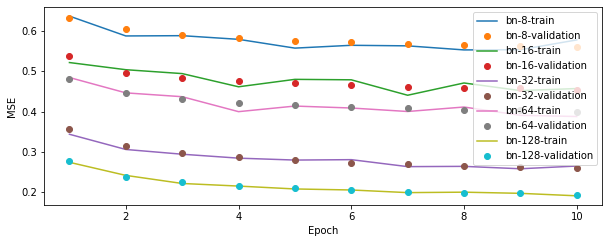

In [16]:
epochs = range(1, hparams['num_epochs'] + 1)
plt.figure(figsize=(10, 8))
plt.subplot(2,1,1)
plt.xlabel('Epoch')
plt.ylabel('MSE')
for bn, loss in losses.items():
  plt.plot(epochs, loss['train_loss'], label='bn-{}-train'.format(bn))
  plt.plot(epochs, loss['val_loss'], 'o', label='bn-{}-validation'.format(bn))
plt.legend()
plt.show()

# <h3><b>Table with MSE on test and validation sets and number of parameters for different bottleneck sizes </h3></b>

In [19]:
atributes = ["bottleneck", "test MSE", "validation MSE", "parameters"]
row_format ="{:>25}" * (len(atributes))
print(row_format.format(*atributes))
for bn, loss in losses.items():
  print(row_format.format(bn, loss['val_loss'][-1],loss['test_loss'][-1],loss['parameters']))




               bottleneck                 test MSE           validation MSE               parameters
                        8       0.5612712502479553        22.12065428495407                    72456
                       16      0.45492082834243774       17.896798133850098                   122640
                       32       0.2601408064365387       10.248353227972984                   223008
                       64      0.39937102794647217       15.689175724983215                   423744
                      128      0.19281651079654694        7.649866580963135                   825216


# <h3><b>Test and display 5 images</h3></b>

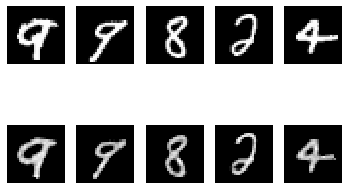

In [20]:
# select N images
N = 5
test_images = random.sample(list(mnist_testset),N)
image_loader = torch.utils.data.DataLoader(
    test_images,
    shuffle=False)
device = hparams['device']

# create plot
f, axarr = plt.subplots(2,N)
for i, (image, label) in enumerate(image_loader):
  with torch.no_grad():
    image = image.to(device)
    output = net(image)
    original_image = image.squeeze().data.numpy()
    output_image = output.squeeze().data.numpy()
    axarr[0,i].imshow(original_image,cmap='gray')
    axarr[0,i].axis('off')
    axarr[1,i].imshow(output_image,cmap='gray')
    axarr[1,i].axis('off')
plt.show()


# <h3><b>Creation of new images with the encoder</h3></b>

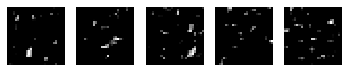

In [21]:
# extract decoder from autoencoder
decoder = net.decoder
# create random input
rand_inputs = torch.randn(5,128)
# plot images from random inputs
f, axarr = plt.subplots(1,N)
for i, rand_input in enumerate(rand_inputs):
  with torch.no_grad():
    rand_input = rand_input.to(device)
    output = decoder(rand_input)
    output_image = output.squeeze().data.numpy()
    axarr[i].imshow(output_image,cmap='gray')
    axarr[i].axis('off')
plt.show()


**Exercice 2:** Transfer learning




1.   Select a subset of 100 images and their associated labels from the MNIST training data.
2.   Select one of the previously trained autoencoders.
3.   Create a digit (0-9) classification model reusing the encoder of the autoencoder and adding the needed fully connected (projection) layer.
4.   Pre-training: use the weights of the autoencoder as initial values for the network weights and train a classification model on the subset of 100 samples.
5.   Fine-tuning: do the same, but train the new projection layer with a normal learning rate and the reused part with a very low learning rate.
6.   From scratch: train the model on the 100 samples without reusing the decoder weights at all.
7.   Show the accuracy of the four models on the MNIST test set in a table.




<h3><b>Create subset of 100 images</h3></b>

In [0]:
train_size = 100
train_images = random.sample(list(mnist_trainset),train_size)
train_loader = torch.utils.data.DataLoader(
    train_images,
    batch_size= train_size,
    shuffle=True)
device = hparams['device']

<h3><b> Select the encoder from the previous exercice </h3></b>

In [0]:
encoder = net.encoder

<h3><b> Create a classificator from the previous encoder and FCL </h3></b>

In [0]:
class Classificator(nn.Module):
  def __init__(self, encoder):
    super().__init__()
    self.encoder = encoder
    self.fc = nn.Sequential(
      nn.Linear(128, hparams['num_classes']),
      nn.LogSoftmax()
    )
  
  def forward(self, x):
    x = self.encoder(x)
    x = self.fc(x)
    return x

<h3><b>Define Train and Test/Validation methods</b></h3>

In [0]:
def correct_predictions(predicted_batch, label_batch):
  pred = predicted_batch.argmax(dim=1, keepdim=True) # get the index of the max log-probability
  acum = pred.eq(label_batch.view_as(pred)).sum().item()
  return acum

def train_class_epoch(train_loader, network, optimizer, criterion, hparams):
  # Activate the train=True flag inside the model
  network.train()
  device = hparams['device']
  avg_loss = None
  avg_weight = 0.1
  for batch_idx, (data, target) in enumerate(train_loader):
      data, target = data.to(device), target.to(device)
      optimizer.zero_grad()
      output = network(data)
      loss = criterion(output, target)
      loss.backward()
      if avg_loss:
        avg_loss = avg_weight * loss.item() + (1 - avg_weight) * avg_loss
      else:
        avg_loss = loss.item()
      optimizer.step()
  return avg_loss

def test_class_epoch(test_loader, network, hparams):
    network.eval()
    device = hparams['device']
    test_loss = 0
    acc = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = network(data)
            test_loss += criterion(output, target, reduction='sum').item() # sum up batch loss
            # compute number of correct predictions in the batch
            acc += correct_predictions(output, target)
    # Average acc across all correct predictions batches now
    test_loss /= len(test_loader.dataset)
    test_acc = 100. * acc / len(test_loader.dataset)
    return test_loss, test_acc

<h3><b> Train the classificator only training the FCL </h3></b>

In [30]:
print("Training only the FCL")
train_losses1 = []
validation_losses1 = []
validation_accs1 = []
class1 = Classificator(encoder.requires_grad_(requires_grad=False))
class1.to(hparams['device'])
optimizer = optim.RMSprop(class1.parameters(), lr=hparams['learning_rate'])
criterion = F.nll_loss

for epoch in range(25):
  train_losses1.append(train_class_epoch(train_loader, class1, optimizer, criterion, hparams))
  te_loss, te_acc = test_class_epoch(test_loader, class1, hparams)
  validation_losses1.append(te_loss)
  validation_accs1.append(te_acc)

Training only the FCL


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


<h3><b> Train the classificator using the pretrained weights as initial values </h3></b>

In [32]:
print("Training with the pretarained weights")
train_losses2 = []
validation_losses2 = []
validation_accs2 = []
class2 = Classificator(encoder.requires_grad_(requires_grad=True))
class2.to(hparams['device'])
optimizer = optim.RMSprop(class2.parameters(), lr=hparams['learning_rate'])
criterion = F.nll_loss

for epoch in range(25):
  train_losses2.append(train_class_epoch(train_loader, class2, optimizer, criterion, hparams))
  te_loss, te_acc = test_class_epoch(test_loader, class2, hparams)
  validation_losses2.append(te_loss)
  validation_accs2.append(te_acc)

Training with the pretarained weights


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


<h3><b> Train the classificator with different learning rates </h3></b>

In [34]:
print("Training with different learning rates")
train_losses3 = []
validation_losses3 = []
validation_accs3 = []
class3 = Classificator(encoder.requires_grad_(requires_grad=True))
class3.to(hparams['device'])
optimizer = optim.RMSprop([{'params': class3.encoder.parameters(), "lr": hparams['learning_rate']/10},
                           {'params': class3.fc.parameters(), "lr" :hparams['learning_rate']}])
criterion = F.nll_loss

for epoch in range(25):
  train_losses3.append(train_class_epoch(train_loader, class3, optimizer, criterion, hparams))
  te_loss, te_acc = test_class_epoch(test_loader, class3, hparams)
  validation_losses3.append(te_loss)
  validation_accs3.append(te_acc)

Training with different learning rates


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


<h3><b> Train the classificator from scratch </h3></b>

In [35]:
print("Training from scratch")
train_losses4 = []
validation_losses4 = []
validation_accs4 = []
class4 = Classificator(ConvEncoder(128))
class4.to(hparams['device'])
optimizer = optim.RMSprop(class4.parameters(), lr=hparams['learning_rate'])
criterion = F.nll_loss

for epoch in range(25):
  train_losses4.append(train_class_epoch(train_loader, class4, optimizer, criterion, hparams))
  te_loss, te_acc = test_class_epoch(test_loader, class4, hparams)
  validation_losses4.append(te_loss)
  validation_accs4.append(te_acc)

Training from scratch


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


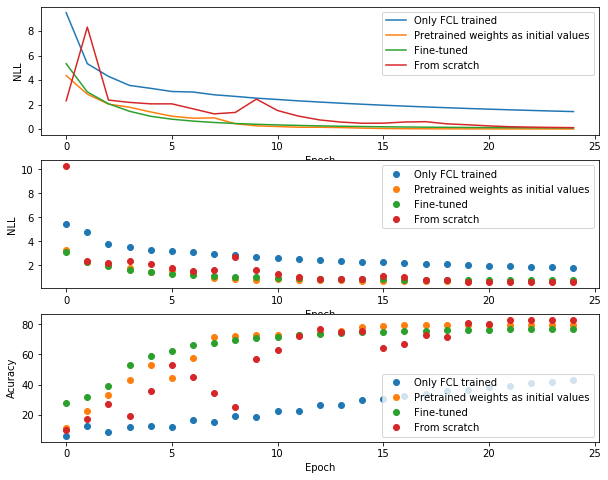

In [36]:
plt.figure(figsize=(10, 8))
plt.subplot(3,1,1)
plt.xlabel('Epoch')
plt.ylabel('NLL')
plt.plot(train_losses1, label='Only FCL trained'.format(1))
plt.plot(train_losses2, label='Pretrained weights as initial values'.format(2))
plt.plot(train_losses3, label='Fine-tuned'.format(3))
plt.plot(train_losses4, label='From scratch'.format(4))
plt.legend()
plt.subplot(3,1,2)
plt.xlabel('Epoch')
plt.ylabel('NLL')
plt.plot(validation_losses1,'o', label='Only FCL trained'.format(1))
plt.plot(validation_losses2,'o', label='Pretrained weights as initial values'.format(2))
plt.plot(validation_losses3,'o', label='Fine-tuned'.format(3))
plt.plot(validation_losses4,'o', label='From scratch'.format(4))
plt.legend()
plt.subplot(3,1,3)
plt.xlabel('Epoch')
plt.ylabel('Acuracy')
plt.plot(validation_accs1,'o', label='Only FCL trained'.format(1))
plt.plot(validation_accs2,'o', label='Pretrained weights as initial values'.format(2))
plt.plot(validation_accs3,'o', label='Fine-tuned'.format(3))
plt.plot(validation_accs4,'o', label='From scratch'.format(4))
plt.legend()
plt.show()